In [115]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

#### Initialize Spark Session

In [116]:
spark = SparkSession.builder.appName("CarAnalysisApp").getOrCreate()

#### Load the dataset

In [117]:
dataset_path = "datasets/car_prices.csv"
df = spark.read.options(header="True", inferSchema="True").csv(dataset_path)

#### Dataframe Schema

In [118]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: integer (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)



In [119]:
print(f"dataframe count: {df.count()}")

dataframe count: 558837


#### Selecting only the usefull columns for this example

- **year**: The manufacturing year of the vehicle.
- **make**: The brand or manufacturer of the vehicle.
- **model**: The specific model of the vehicle.
- **transmission**: The type of transmission in the vehicle (e.g., automatic).
- **mmr**: Manheim Market Report, possibly indicating the estimated market value of the vehicle.
- **sellingprice**: The price at which the vehicle was sold.

In [120]:
df = df.select(["year", "make", "model", "transmission", "mmr", "sellingprice"])
df.show()

+----+---------+-------------------+------------+-----+------------+
|year|     make|              model|transmission|  mmr|sellingprice|
+----+---------+-------------------+------------+-----+------------+
|2015|      Kia|            Sorento|   automatic|20500|       21500|
|2015|      Kia|            Sorento|   automatic|20800|       21500|
|2014|      BMW|           3 Series|   automatic|31900|       30000|
|2015|    Volvo|                S60|   automatic|27500|       27750|
|2014|      BMW|6 Series Gran Coupe|   automatic|66000|       67000|
|2015|   Nissan|             Altima|   automatic|15350|       10900|
|2014|      BMW|                 M5|   automatic|69000|       65000|
|2014|Chevrolet|              Cruze|   automatic|11900|        9800|
|2014|     Audi|                 A4|   automatic|32100|       32250|
|2014|Chevrolet|             Camaro|   automatic|26300|       17500|
|2014|     Audi|                 A6|   automatic|47300|       49750|
|2015|      Kia|             Optim

In [121]:
sales_total = df.agg(F.sum("sellingprice")).first()[0]
print(f"sales total: {sales_total}")

sales total: 7606367587


In [122]:
min_date = df.select(F.min("year")).first()[0]
max_date = df.select(F.max("year")).first()[0]
print(f"Dates range: {min_date}-{max_date}")

Dates range: 1982-2015


#### Tasks:
##### 1. Identifying popular car models and manufacturers.
##### 2. Analyzing trends in sales based on factors like price, year and transmission type.
##### 3. Calculating descriptive statistics like average price, etc.

#### Best selling car models

In [123]:
df_top_models = (
    df.groupBy("make", "model")
    .agg(F.sum("sellingprice").alias("total_sellingprice"))
    .sort(F.col("total_sellingprice").desc())
)
df_top_models.show()

+-------------+----------------+------------------+
|         make|           model|total_sellingprice|
+-------------+----------------+------------------+
|         Ford|           F-150|         272669759|
|       Nissan|          Altima|         220986008|
|         Ford|          Escape|         165884802|
|         Ford|          Fusion|         159912520|
|     Infiniti|         G Sedan|         147918806|
|         Ford|        Explorer|         140340694|
|       Toyota|           Camry|         140246808|
|          BMW|        3 Series|         137906230|
|         Ford|            Edge|         110867719|
|    Chevrolet|  Silverado 1500|         107318746|
|         Ford|           Focus|          96855026|
|Mercedes-Benz|         C-Class|          95178932|
|         null|            null|          92356133|
|        Dodge|   Grand Caravan|          90626043|
|          BMW|        5 Series|          88530025|
|        Honda|          Accord|          88147775|
|     Chrysl

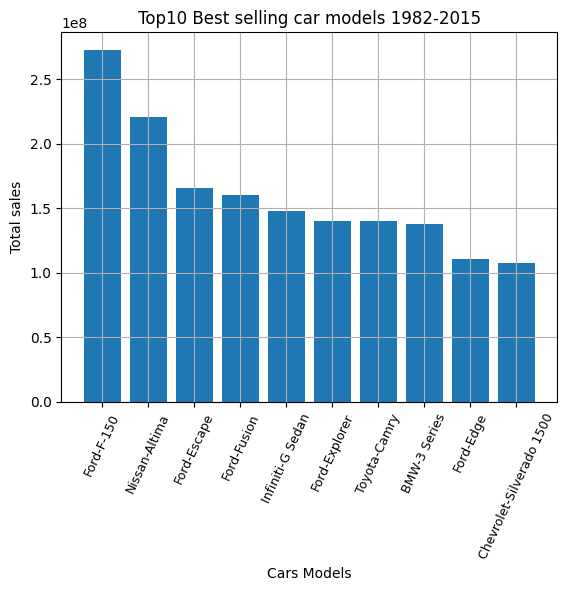

In [124]:
top10_models = {f'{row[0]}-{row[1]}' : row[2] for row in df_top_models.take(10)}
lists = top10_models.items()
xpoints, ypoints = zip(*lists)
plt.title(f"Top10 Best selling car models {min_date}-{max_date}")
plt.xlabel("Cars Models")
plt.ylabel("Total sales")
plt.xticks(rotation=65, fontsize=9)  # Rotate and increase font size
plt.grid(True)
plt.bar(xpoints, ypoints)
plt.show()

#### Best selling car manufacturers

In [125]:
df_top_manufacturers = (
    df.groupBy("make")
    .agg(F.sum("sellingprice").alias("total_sellingprice"))
    .sort(F.col("total_sellingprice").desc())
    .withColumn(
        "percentage",
        (F.round(F.col("total_sellingprice") / F.lit(sales_total) * 100, 2)),
    )
)
df_top_manufacturers.show()

+-------------+------------------+----------+
|         make|total_sellingprice|percentage|
+-------------+------------------+----------+
|         Ford|        1360304557|     17.88|
|    Chevrolet|         721003399|      9.48|
|       Nissan|         633272955|      8.33|
|       Toyota|         488392710|      6.42|
|          BMW|         444254638|      5.84|
|Mercedes-Benz|         370083906|      4.87|
|        Dodge|         344138494|      4.52|
|     Infiniti|         312489190|      4.11|
|        Honda|         297645409|      3.91|
|        Lexus|         240615055|      3.16|
|      Hyundai|         240152886|      3.16|
|         Jeep|         230583753|      3.03|
|          Kia|         213441763|      2.81|
|     Chrysler|         192903066|      2.54|
|          GMC|         179905320|      2.37|
|   Volkswagen|         118056384|      1.55|
|         Audi|         116883675|      1.54|
|          Ram|         115721911|      1.52|
|     Cadillac|         114447871|

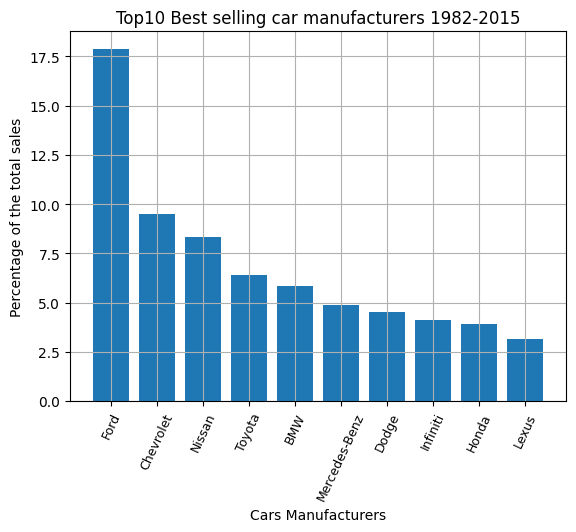

In [126]:
df_top10_manufacturers = {row[0]:row[2] for row in df_top_manufacturers.take(10)}
lists = df_top10_manufacturers.items()
xpoints, ypoints = zip(*lists)
plt.title(f"Top10 Best selling car manufacturers {min_date}-{max_date}")
plt.xlabel("Cars Manufacturers")
plt.ylabel("Percentage of the total sales")
plt.xticks(rotation=65, fontsize=9)  # Rotate and increase font size
plt.grid(True)
plt.bar(xpoints, ypoints)
plt.show()

#### Number of cars sold by transmission type over the years

In [127]:
df_sales_by_transmission_type = (
    df.select(["year", "transmission"])
    .filter(
        ((F.col("transmission") == "automatic") | (F.col("transmission") == "manual"))
    )
    .groupBy(["year", "transmission"])
    .agg(F.count("*").alias("count"))
    .sort(F.col("year").desc(), F.col("count").desc())
)
df_sales_by_transmission_type.show()

+----+------------+-----+
|year|transmission|count|
+----+------------+-----+
|2015|   automatic| 8108|
|2015|      manual|  141|
|2014|   automatic|69042|
|2014|      manual| 1369|
|2013|   automatic|85942|
|2013|      manual| 2009|
|2012|   automatic|86585|
|2012|      manual| 2164|
|2011|   automatic|40835|
|2011|      manual| 1308|
|2010|   automatic|22540|
|2010|      manual|  986|
|2009|   automatic|17687|
|2009|      manual|  857|
|2008|   automatic|26981|
|2008|      manual| 1347|
|2007|   automatic|26533|
|2007|      manual| 1282|
|2006|   automatic|23155|
|2006|      manual| 1216|
+----+------------+-----+
only showing top 20 rows



In [128]:
df_sales_by_transmission_type.count()

64

In [129]:
data = {}
for year, tssion, count in df_sales_by_transmission_type.collect():
    if not year in data:
        data[year] = [0, 0]
    idx = 0 if tssion == 'automatic' else 1
    data[year][idx] = count

xyears = list(data.keys())
automatic_points, manual_points = zip(*list(data.values()))

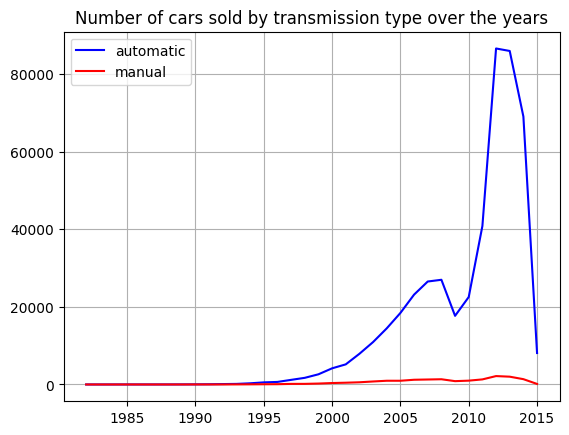

In [139]:
plt.title(f"Number of cars sold by transmission type over the years")
plt.grid(True)
plt.plot(xyears, automatic_points, label='automatic', color='blue')
plt.plot(xyears, manual_points, label='manual', color='red')
plt.legend()
plt.show()

#### Percentage of sales that exceed that expected price of the car
> Given that the documentation says that the mmr column is the estimated value of the price of the car,
it is interesting to calculate the percentage of sales that exceed that expected price

In [131]:
df_overestimation_selling = (
    df.select(["mmr", "sellingprice"])
    .withColumn(
        "sold_over_estimation",
        F.when((F.col("mmr")) < (F.col("sellingprice")), 1).otherwise(0),
    )
    .agg(
        F.sum("sold_over_estimation").alias("sold_over_estimation_total"),
        F.round(((100 * F.sum("sold_over_estimation")) / df.count()), 2).alias(
            "sold_over_estimation_percentage"
        ),
    )
)
df_overestimation_selling.show(10)

+--------------------------+-------------------------------+
|sold_over_estimation_total|sold_over_estimation_percentage|
+--------------------------+-------------------------------+
|                    261161|                          46.73|
+--------------------------+-------------------------------+



#### For those of you who are JDMs car enthusiasts, the Nissan GT-R Skyline is a legend, so let's find out according to this dataset how its price has behaved over time

In [132]:
df_gtr = df.select(["year", "sellingprice"]).filter(
    (F.col("make") == "Nissan") & (F.col("model") == "GT-R")
)
gtr_min_price = df_gtr.select(F.min("sellingprice").alias("min")).collect()[0][0]
gtr_max_price = df_gtr.select(F.max("sellingprice").alias("max")).collect()[0][0]

print("Nissan GT-R")
print(f"Lowest price: {gtr_min_price}")
print(f"Highest price: {gtr_max_price}")
print("Average price over the years:")
df_gtr_prices = df_gtr.groupBy("year").agg(F.round(F.avg("sellingprice")).alias("avg_price")).sort(
    "year"
)
df_gtr_prices.show()

Nissan GT-R
Lowest price: 46500
Highest price: 86400
Average price over the years:
+----+---------+
|year|avg_price|
+----+---------+
|2009|  50375.0|
|2010|  54500.0|
|2012|  64010.0|
|2013|  70169.0|
|2014|  76600.0|
|2015|  80274.0|
+----+---------+



In [133]:
gtr_data = {year:avg_price for year, avg_price in df_gtr_prices.collect()}
lists = gtr_data.items()
xpoints, ypoints = zip(*lists)

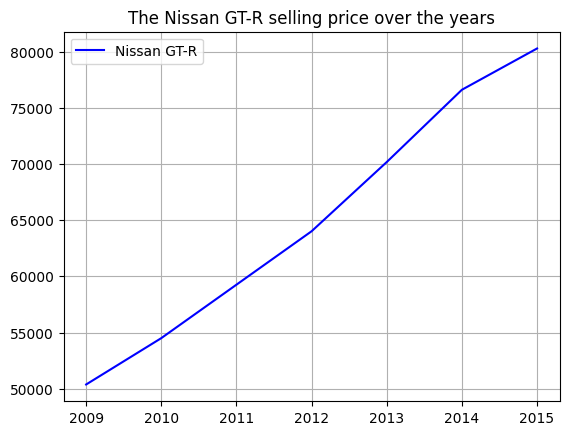

In [138]:
plt.title(f"The Nissan GT-R selling price over the years")
plt.grid(True)
plt.plot(xpoints, ypoints, label='Nissan GT-R', color='blue')
plt.legend()
plt.show()

### Conclusions

After analyzing the dataset, I was able to conclude that:

1. Ford Motor Company is the manufacturer and seller of the most cars by far.

2. The difference in cars sold with automatic transmission far exceeds those with manual transmission over the years, which is understandable due to the comfort and simplicity that this type of transmission provides for driving, especially in cities.

3. The selling price exceeded the estimated selling price of the car in 46.73% of cases, a clear example of the increase in the market economy.

4. Finally, as a curiosity, it can be clearly observed how the price of the Nissan GT-R has a constant growth over the years due to the popularity it achieved after movies like Fast and Furious.